# Train UNet Model

In this Notebook you will learn how to train your UNet architecture with Dataloop and Pytorch

UNet is an Encoder - Decoder architecture for creating segmentation maps

In [1]:
import json
import torch
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import dtlpy as dl
from dtlpy.ml import train_utils
from dtlpy.ml.dataset_generators.torch_dataset_generator import DataGenerator
import tempfile

In [2]:
# clean up the GPU
import gc
gc.collect()
torch.cuda.empty_cache()

### Get the DataLoop entities

lets get the model and dataset entities from our dataloop platform

In [3]:
model = dl.models.get('unet')  # This is the global model
# Data entities
project = dl.projects.get('shefi-contests', '50f0fc03-4d70-455d-b485-c78cca53f2be')
dataset = dl.datasets.get('carvana', '61b9bbc1e8ad454a9aa7d285')

### Snapshot

Now we can create a new snapshot - we will add your name and data to the suffix to make the snapshot has a unique name

In [4]:
whoami = dl.client_api.info()['user_email']
now = datetime.datetime.now()

# Create a new snapshot - personally and with currect datetime
snapshot_name = f"carvana-train-example-{whoami.split('@')[0]}-{now.isoformat(timespec='minutes')}"
snapshot = model.snapshots.create(
    snapshot_name=snapshot_name,
    dataset_id=dataset.id,
    description='train unet example',
    bucket=project.buckets.create(bucket_type=dl.BucketType.ITEM, model_name=model.name, snapshot_name=snapshot_name),
    tags=['example', 'notebook'],
    configuration={'id_to_label_map': {'1': 'car'},
                   'image_normalize_mu': 0, 'image_normalize_std': 1,
                   'input_shape': [640, 960], 'batch_size': 2,
                   'num_epochs': 2},
    project_id=project.id,
    labels=['car']
)

2022-01-03 13:02:33.649 [ERROR]-[MainThread]-[v1.47.1]dtlpy.repositories.snapshots: Snapshot does not support 'unlocked dataset'. Please change 'carvana' to readonly


### Lets View the Model and Snapshot entities

We use the to_df in order to convert to a DataFrame and view it

In [5]:
model.to_df()

,id,creator,name,description,version,tags,inputType,outputType,projectId,entryPoint,className,codebase,createdAt
0,619d001117bf2dab2b6aa4c3,yair@dataloop.ai,unet,Global Dataloop U-net implemented in pytorch,1.0.1,"[torch, unet, semantic]",image,binary,296bc0d5-46fc-447f-b3ee-25899e7268bc,unet_adapter.py,UNetAdapter,"{'type': 'git', 'gitUrl': 'https://github.com/...",2021-11-23T14:52:01.787Z


In [6]:
snapshot.to_df()

,id,creator,name,description,is_global,status,tags,configuration,modelId,projectId,datasetId,createdAt,bucket,ontologySpec
0,61d2f458c1aaaa764d669897,yair@dataloop.ai,carvana-train-example-yair-2022-01-03T13:02,train unet example,False,created,"[example, notebook]","{'id_to_label_map': {'1': 'car'}, 'image_norma...",619d001117bf2dab2b6aa4c3,50f0fc03-4d70-455d-b485-c78cca53f2be,61b9bbc1e8ad454a9aa7d285,2022-01-03T13:04:24.133Z,"{'type': 'item', 'itemId': '61d2f45880d978833d...","{'labels': ['car'], 'ontologyId': 'null'}"


### One last thing to make sure before we train

Our `adapter` train method expects the data to be organized as: train-validation-test  
this can be created manually on small datasets using `train_utils.create_dataset_partition()`

Our dataset is already prepared, we will just verify it

In [7]:
train_items = dataset.get_partitions(partitions=dl.SnapshotPartitionType.TRAIN)
val_items = dataset.get_partitions(partitions=dl.SnapshotPartitionType.VALIDATION)
test_items = dataset.get_partitions(partitions=dl.SnapshotPartitionType.TEST)

print(f"Dataset {dataset.name} Data partition, TRAIN: {train_items.items_count}, VALIDATION {val_items.items_count}, TEST {test_items.items_count} ")

Dataset carvana Data partition, TRAIN: 4070, VALIDATION 1018, TEST 0 


### Finally we can start to train

We initialize the adapter using the `build` method.

The `Adapter` is the base class to connect between dataloop platform and our specific model  
some method are inheritance from the base adapter and some are written specifically per model
each architecture has it's own adapter which you can view it's raw code


In [8]:
adapter = model.build()
adapter.load_from_snapshot(snapshot=snapshot)
# adapter._set_adapter_handler('DEBUG')

W: unet-adapter         13:02:39 [unet_adapter.py:94](load):: Missing model path: '/home/shefi/.dataloop/snapshots/carvana-train-example-yair-2022-01-03T13:02/model.pth', Creating default UNet arch with 2 classes 
classes: {'car'}
I: unet-adapter         13:02:39 [unet_adapter.py:102](load):: Initializing data transforms. augment rate: 0.5 Image Normalizations: mean: 0, std: 1


In [9]:
root_path, data_path, output_path = adapter.prepare_training()

W: unet-adapter         13:02:40 [base_model_adapter.py:175](prepare_training):: Data path directory (/home/shefi/.dataloop/datasets/61b9bbc1e8ad454a9aa7d285) is not empty..
I: unet-adapter         13:04:19 [base_model_adapter.py:191](prepare_training):: Downloaded <SnapshotPartitionType.TRAIN: 'train'> SnapshotPartition complete. 4070 total items
I: unet-adapter         13:04:54 [base_model_adapter.py:191](prepare_training):: Downloaded <SnapshotPartitionType.VALIDATION: 'validation'> SnapshotPartition complete. 1018 total items
I: unet-adapter         13:04:54 [base_model_adapter.py:191](prepare_training):: Downloaded <SnapshotPartitionType.TEST: 'test'> SnapshotPartition complete. 0 total items


In [10]:
adapter.train(data_path=data_path, output_path=output_path,)

Loading Data Generator: 100%|██████████| 1018/1018 [00:19<00:00, 52.19it/s]
I: unet-adapter         13:06:15 [unet_adapter.py:233](train):: Network:
	3 input channels
	2 output channels (classes)
	Bilinear up-scaling
I: unet-adapter         13:06:15 [unet_adapter.py:237](train):: Model loaded from model.pth
I: unet-adapter         13:06:23 [unet_adapter.py:266](train):: Starting training:
            Epochs:          2
            Batch size:      2
            Learning rate:   1e-05
            Training size:   4070
            Validation size: 1018
            Device:          cuda:0
            Images shape:    [640, 960]
            Mixed Precision: False
            Output:          /home/shefi/.dataloop/training/61d2f458c1aaaa764d669897_20220103-130239/output
            TensorBoard:     /home/shefi/.dataloop/training/61d2f458c1aaaa764d669897_20220103-130239/output/tb
        
Epoch 1/2:   0%|          | 0/4070 [00:00<?, ?img/s]/opt/conda/lib/python3.7/site-packages/torch/nn/func


### SAVING

The current adapter now holds the best model fit for our data.

In order to upload the weights and other configurations we need to save our snapshot.  
We will use a temp dir - so we save all content to that dir and upload it (other option is to upload all the *`output_path`* which has more runtime files)

In [11]:
temp_dir = tempfile.mkdtemp(prefix=snapshot.name, suffix=now.strftime('%F-%H%M%S'))
adapter.save_to_snapshot(local_path=temp_dir)


## USING THE MODEL - PREDICTION

We will use the DataGenerator to view the image (this utility already connects with our dataloop item and annotations)


In [12]:
datagen = DataGenerator(data_path=os.path.join(data_path, 'validation'),
                        dataset_entity=snapshot.dataset,
                        annotation_type=dl.AnnotationType.SEGMENTATION,
)


Loading Data Generator: 100%|██████████| 1018/1018 [00:53<00:00, 19.13it/s]


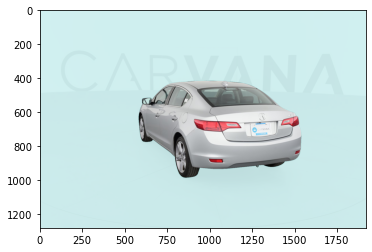

In [13]:
# example - get 1 entry and visualize it
datagen.visualize(20)

### Data Item

Our data generator returns Data Item dictionary  
we can parse it to get the item and annotations


In [14]:
data_item = datagen[20]
print(f"To get the item_id from the dataItem ({data_item.keys()}) object we can use the ann json")
ann_json = json.load(open(data_item['annotation_filepath'], 'r'))
item_id = ann_json['id']
item = dl.items.get(item_id=item_id)

To get the item_id from the dataItem (dict_keys(['image_filepath', 'box', 'class', 'labels', 'binary', 'annotation_filepath', 'item_id', 'image', 'annotations'])) object we can use the ann json


In [15]:
predictions = adapter.predict_items(items=[item], with_upload=False)
item_predictions = predictions[0]

predicting: 100%|██████████| 1/1 [00:00<00:00,  1.58bt/s]


predicting: 100%|██████████| 1/1 [00:00<00:00,  1.74bt/s]



+----+------+-----------+--------+--------------------------+--------+------------------------------------+-----------+-------------+-------------+----------+--------------------------+--------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
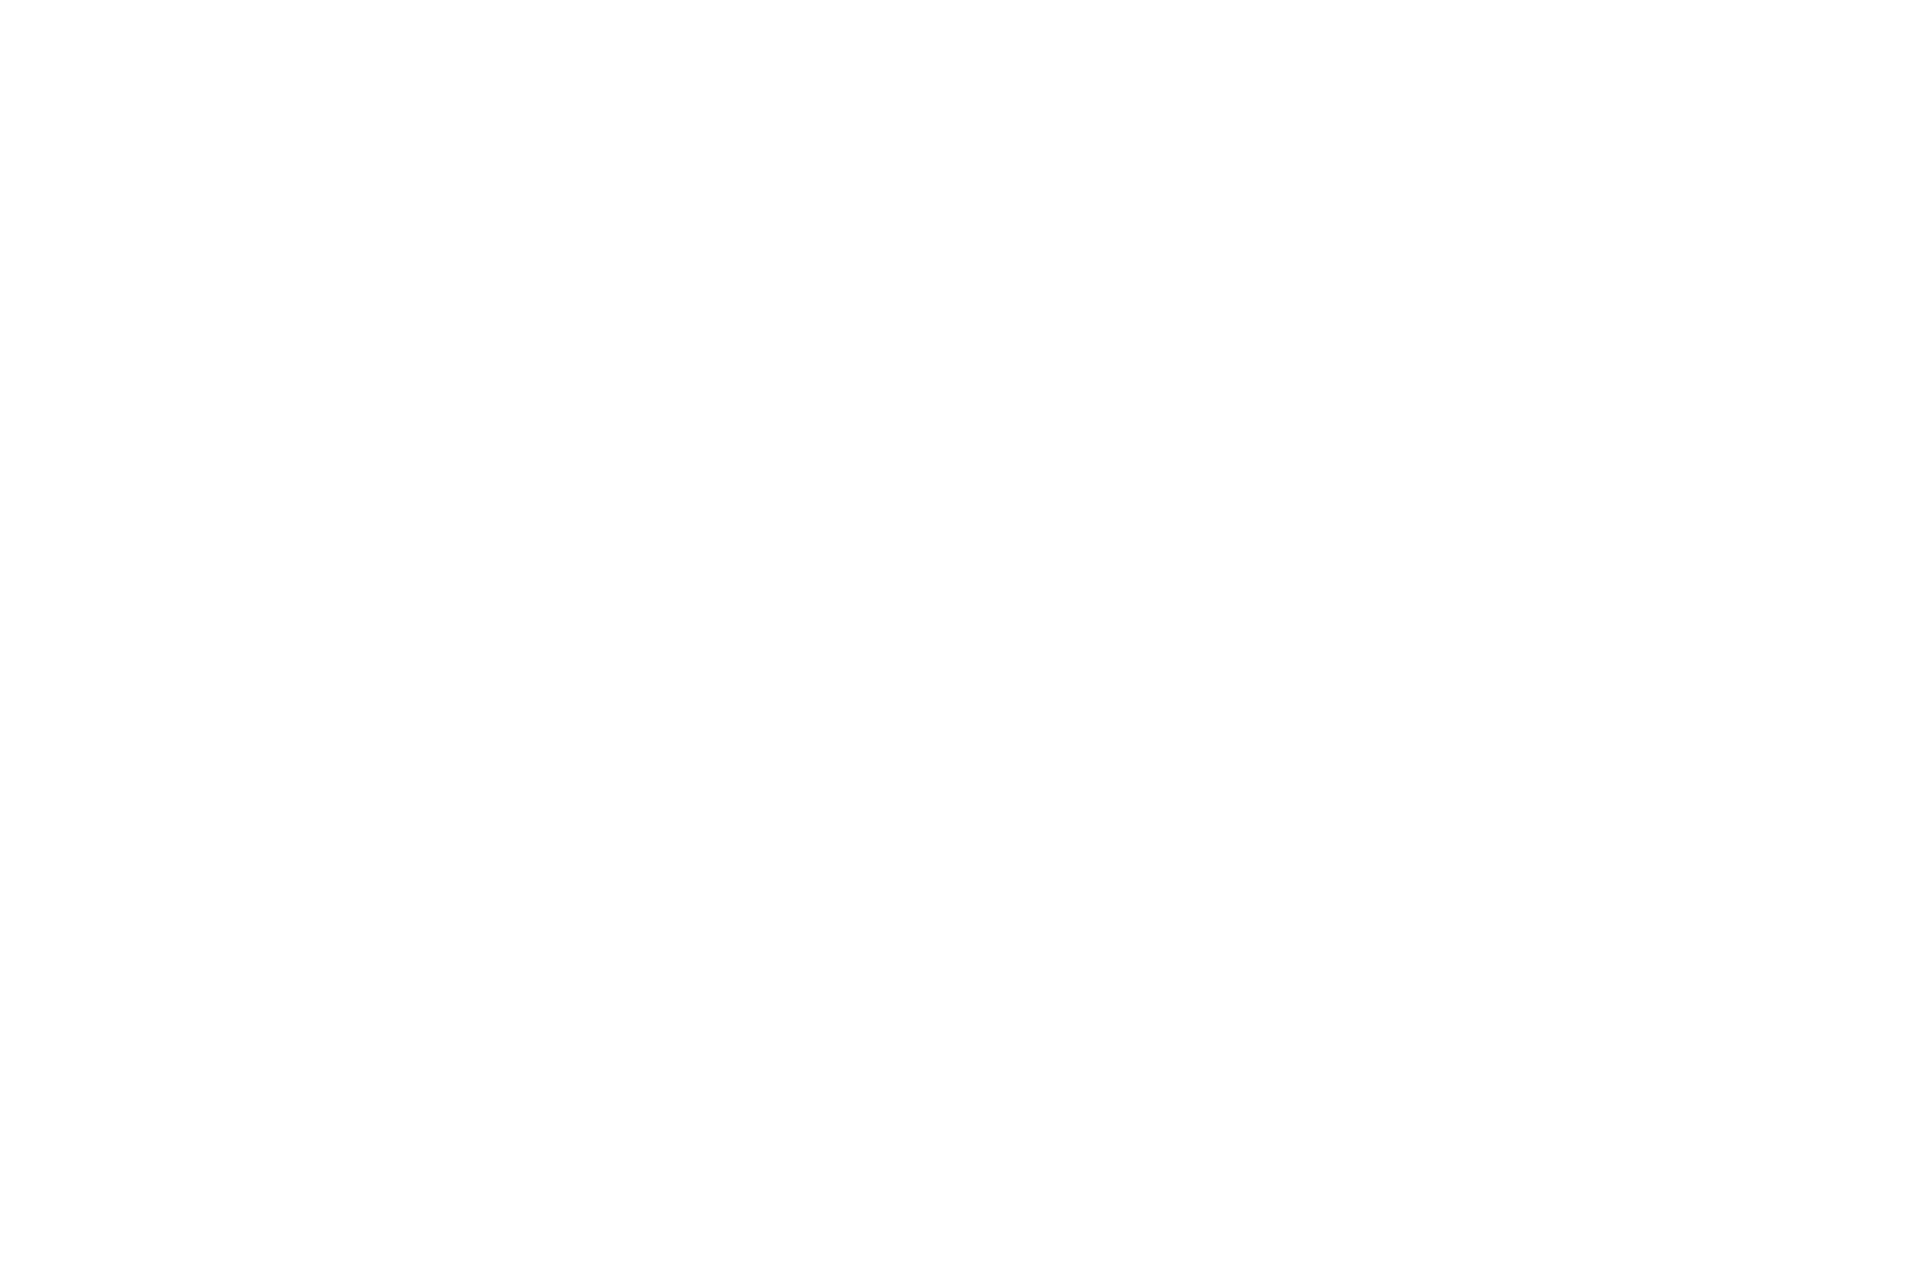
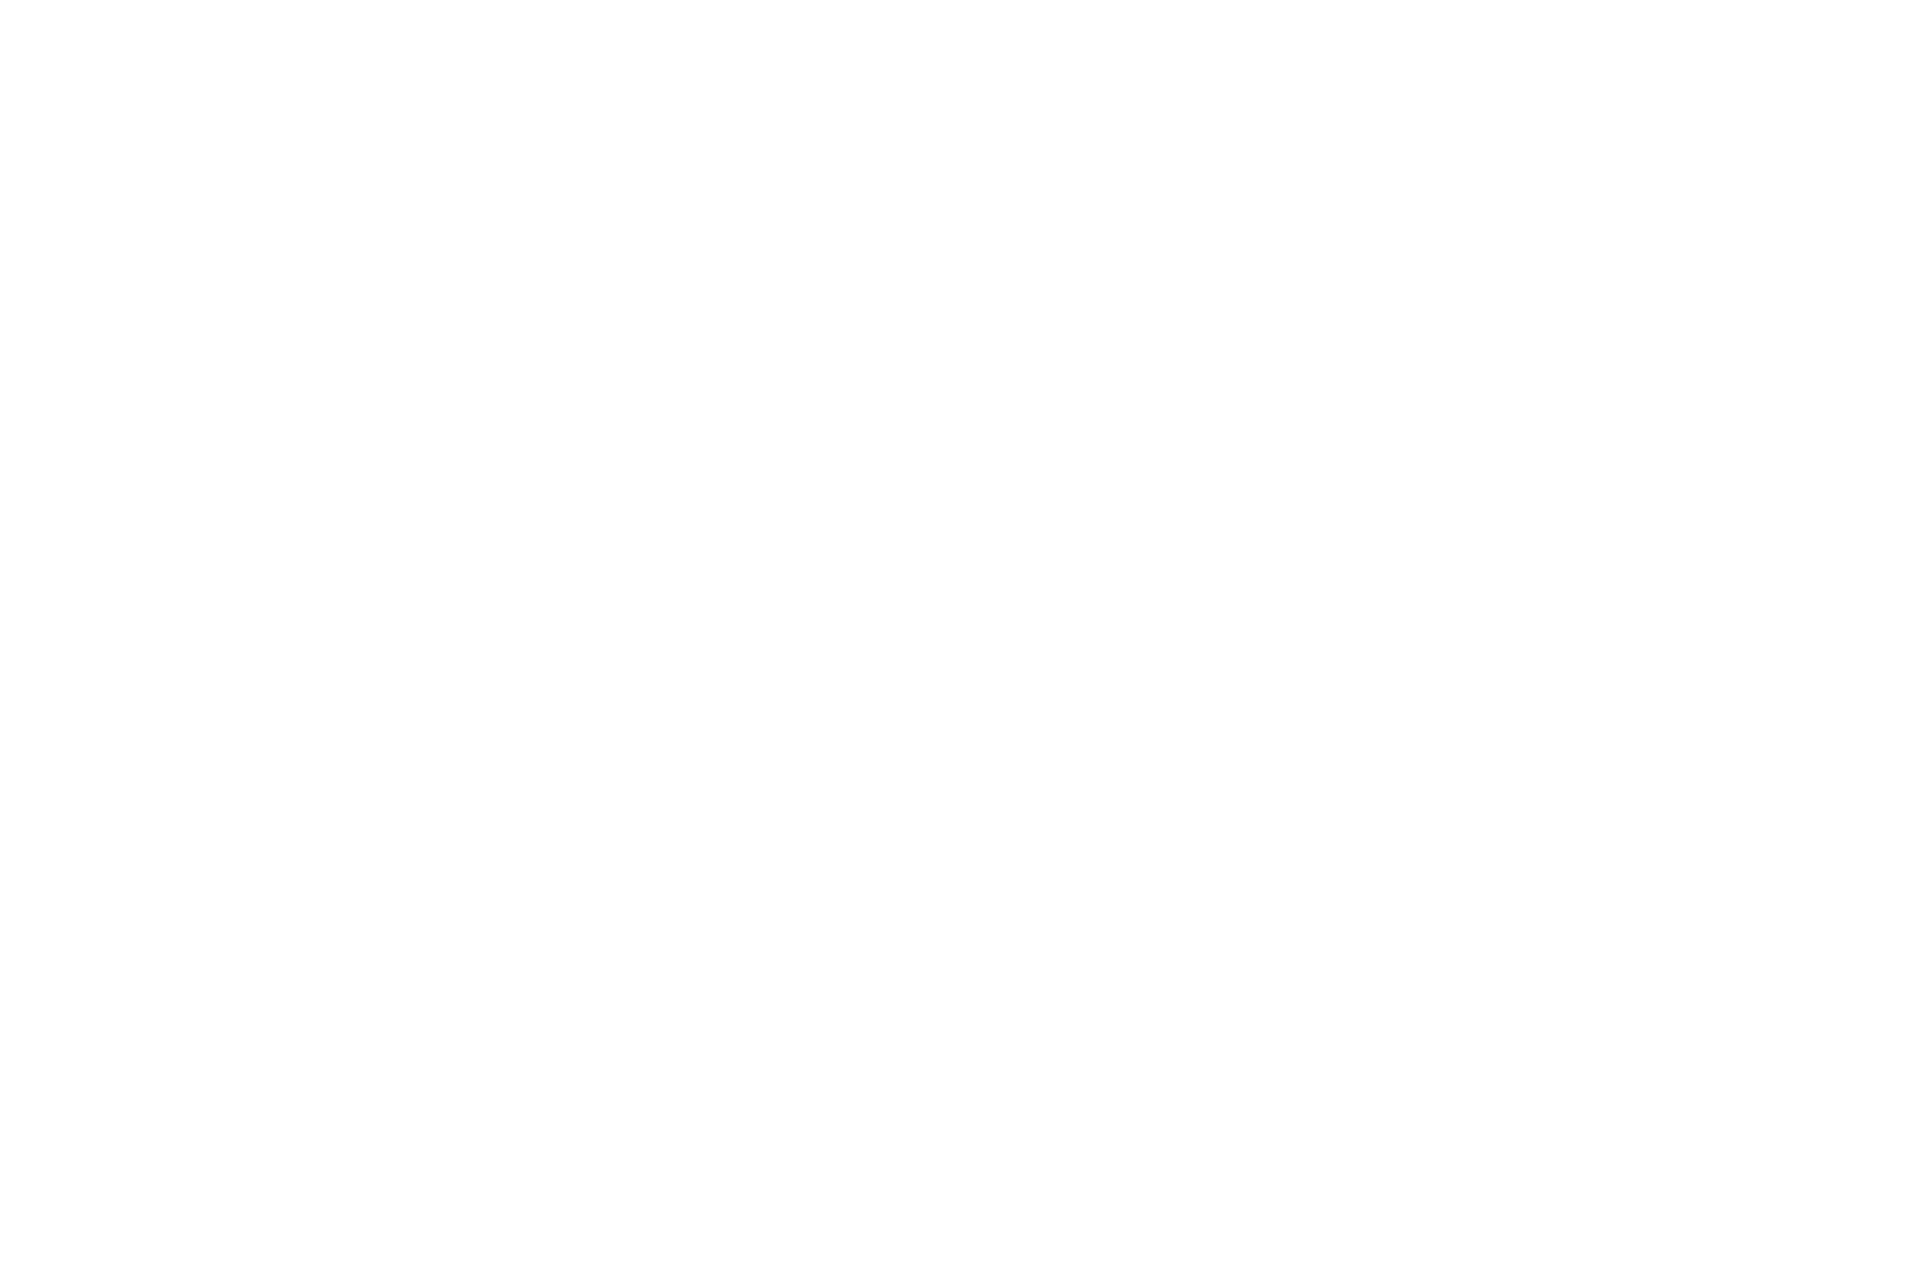

In [16]:
# we can ignore the label 0 which usually uses for background
predictions = adapter.predict_items(items=[item], with_upload=False, with_bg=False)
item_sematic_preds = predictions[0]
item_sematic_preds.print()

In [17]:
# we can create polygons instead of sematic segmetations
predictions = adapter.predict_items(items=[item], with_upload=False, to_poly=True)
item_polygons_preds = predictions[0]
item_polygons_preds.print()

predicting: 100%|██████████| 1/1 [00:00<00:00,  1.78bt/s]


+----+------+-----------+--------+--------------------------+--------+---------+-----------+-------------+-------------+----------+--------------------------+---------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

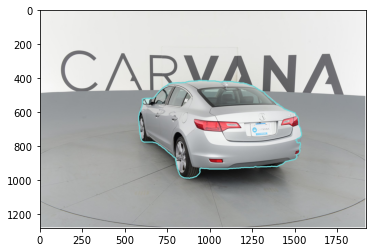

In [18]:
annotated = item_polygons_preds.show(data_item['image'], thickness=5 )
plt.imshow(annotated)